In [339]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, Label
from math import exp

In [340]:
def data_processing(dataFrame, noncat_features, cat_features):
    x_vals = dataFrame[noncat_features]
    x_vals_cat = dataFrame[cat_features]
    x_vals_cat = pd.get_dummies(x_vals_cat, columns=cat_features)
    scaler = MinMaxScaler().fit(x_vals)
    x_vals = scaler.transform(x_vals)
    x_vals = pd.DataFrame(x_vals, columns=noncat_features)
    x_vals["unemployed"], x_vals["employed"] = x_vals_cat.iloc[:,0], x_vals_cat.iloc[:,1]
    x_vals.insert(loc=0, column="placeholder", value=np.ones(len(x_vals)))
    y_vals = dataFrame.iloc[:, -1]
    x_vals_train, x_vals_test, y_vals_train, y_vals_test = train_test_split(x_vals, y_vals, random_state=25)
    x_vals_train, x_vals_test, y_vals_train, y_vals_test = x_vals_train.to_numpy(), x_vals_test.to_numpy(), \
                                                           y_vals_train.to_numpy(), y_vals_test.to_numpy()
    return x_vals_train, x_vals_test, y_vals_train, y_vals_test


def get_theta(coef, x):
    theta = 0.0
    for i in range(0, len(x)):
        theta = theta + (coef[i] * x[i])
    return theta


# This function returns the prediction based on the output of
# theta
def get_prediction(theta):
    prediction = 1 / (1 + np.exp(-theta))
    return prediction

# Takes array of coefficients previously used, the dependent
# variable values, the predicted value, the alpha, which
# will default to 0.3, and the array of x values
# This function will calculate the new coefficients and return
# them in the form of an array

def update_coef(coef_array, x_array, y, prediction, alpha):
    new_coef = []
    for i in range(0, len(x_array)):
        coef = coef_array[i] + alpha * (y - prediction) * prediction * (1 - prediction) * x_array[i]
        new_coef.append(coef)
    return new_coef

# Takes array
# Takes an array of x values, an array of coefficients,a "y"
# value and an alpha value, builds the theta value runs theta
# through the sigmoid function and runs that through the
# gradient descent algorithm, update_coef and returns an
# array of coefficients which will be used by the model with
# the non-training data.

def initialize_model(train_row, y, learning_rate):
    # initialize coefficient array with all 0.0
    initial_coef = []
    for i in range(0, len(train_row)):
        initial_coef.append(0.0)
    x_vals = train_row
    y = y
    theta = get_theta(initial_coef, x_vals)
    prediction = get_prediction(theta)
    return update_coef(initial_coef, x_vals, y, prediction, learning_rate)

# Takes independent variables as array, coefficients as array,
# dependent variabls as array, and a learning rate as a float
# Generates theta value using coefficients
def build_model_epoch(independent_variables, coef, dependent_variables, learning_rate):

    coefficients = coef
    predictions = []
    for i in range(0, len(independent_variables)):
        theta = get_theta(coefficients, independent_variables[i])
        prediction = get_prediction(theta)
        coefficients = update_coef(coefficients, independent_variables[i], \
                                        dependent_variables[i], prediction, learning_rate)
        if prediction < 0.5:
            predictions.append(0)
        else:
            predictions.append(1)
            
    one_is_one, zero_is_zero, one_is_zero, zero_is_one = get_raw_test_results(predictions, dependent_variables)
    score = get_score(one_is_one, zero_is_zero, one_is_zero, zero_is_one)
    

    return coefficients, score

def build_model(learning_rate, epoch_count, independent_variables, dependent_variables):
    coefficients = initialize_model(independent_variables[0], dependent_variables[0], learning_rate)
    scores = []
    for i in range(0, epoch_count):
        coefficients, score = build_model_epoch(independent_variables, coefficients, dependent_variables,
                                              learning_rate)
        scores.append(score)

    return coefficients, scores


def test_model(model_coef, test_inde_vars):
    coef = model_coef
    predictions = []
    for i in range(0, len(test_inde_vars)):
        theta = get_theta(coef, test_inde_vars[i])
        prediction = get_prediction(theta)
        if prediction < 0.5:
            predictions.append(0)
        else:
            predictions.append(1)
    return predictions

def get_raw_test_results(test, y_vals_test):
    one_is_one = 0
    zero_is_zero = 0
    one_is_zero = 0
    zero_is_one = 0

    for i in range(0, len(test)):
        if test[i] == 1 and y_vals_test[i] == 1:
            one_is_one += 1
        elif test[i] == 0 and y_vals_test[i] == 0:
            zero_is_zero += 1
        elif test[i] == 0 and y_vals_test[i] == 1:
            one_is_zero += 1
        else:
            zero_is_one += 1
    return one_is_one, zero_is_zero, one_is_zero, zero_is_one

def get_score(one_is_one, zero_is_zero, one_is_zero, zero_is_one):
    total = one_is_one + zero_is_zero + one_is_zero + zero_is_one
    total_correct = one_is_one + zero_is_zero
    score = total_correct / total * 100
    return score

def standardize_value(series, original_value):
    incoming_series = series
    incoming_value = {'a': original_value}
    print(incoming_value)
    incoming_value = pd.Series(data=incoming_value, index=['a'])
    incoming_series = incoming_series.append(incoming_value, ignore_index=True)
    incoming_series = incoming_series.to_numpy()
    incoming_series = incoming_series.reshape(-1, 1) 
    scaler = MinMaxScaler().fit(incoming_series)
    transformed_values = scaler.transform(incoming_series)
    return transformed_values[0,-1]

def predict_default(model, predictors):
    theta = get_theta(model, predictors)
    prediction = get_prediction(theta)
    if prediction < 0.5:
        return "This customer will likely not default."
    else:
        return "This customer will likely default."

In [341]:
# Pull csv training dataset into Pandas dataframe
# Split dataframe into dependent and independent variables
# Normalize x values using min/max scaler
# Add placeholder value of 1 to x values array to account for
# the intercept coefficient
# Split dep and indep dataframes into training and test
training_data_set = pd.read_csv("Default_Fin.csv")
noncat_features = ["Bank Balance", "Annual Salary"]
cat_features = ["Employed"]

In [342]:
annual_income_text = widgets.BoundedIntText(
    value = 0,
    min = 0,
    max = 1000000000,
    step = 1,
    description = 'Enter the customer\'s annual income',
    disabled = False
)
display(annual_income_text)
print(annual_income_text.value)

BoundedIntText(value=0, description="Enter the customer's annual income", max=1000000000)

0


In [359]:
bank_balance = widgets.BoundedIntText(
                                        value = 0,
                                        min = 0,
                                        max = 1000000000,
                                        step = 1,
                                        disabled = False
                                     )
bank_balance_box = HBox([Label('Enter the customer\'s bank balance: '), bank_balance])
display(bank_balance)

BoundedIntText(value=0, max=1000000000)

In [366]:
print(bank_balance.value)
salary = standardize_value(training_data_set["Annual Salary"], annual_income_text.value)
print(salary)
current_balance = standardize_value(training_data_set["Bank Balance"],  bank_balance.value)
print(current_balance)
employed = 1
unemployed = 0
predictors = np.array([1, salary, current_balance, 0, 1])
print(model)
theta = get_theta(model, predictors)
prediction = 1/ (1 + np.exp(-theta))

20000000
{'a': 200000}
0.598905007896155
{'a': 20000000}
0.000437718
[-4.491646070113095, 8.944341010748994, -0.5703442141854618, -2.349320670078658, -2.1423254000344305]


In [367]:
print(prediction)

0.21799133676371718


In [346]:
x_train, x_test, y_train, y_test = data_processing(training_data_set, noncat_features, cat_features)
model, epoch_scores = build_model( 0.3, 10, x_train, y_train)
print(epoch_scores)
test = test_model(model, x_test)
score1, score2, score3, score4 = get_raw_test_results(test, y_test)
print(score1, score2, score3, score4)
score = get_score(score1, score2, score3, score4)
print(score)

[96.65333333333334, 96.65333333333334, 96.65333333333334, 96.65333333333334, 96.69333333333333, 96.74666666666667, 96.78666666666666, 96.92, 97.01333333333334, 97.13333333333334]
12 2414 70 4
97.04


Text(0.5, 0, 'Epoch Count')

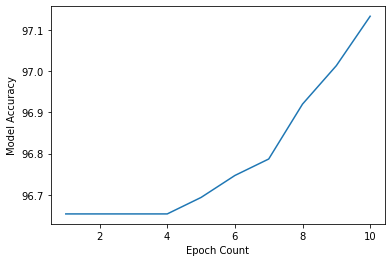

In [347]:
plt.plot(np.linspace(1,10, 10),epoch_scores)
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch Count')